In [13]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize   

tickers = ['AGG_r(t)', 'DBC_r(t)', 'VTI_r(t)','^VIX_r(t)']


In [3]:
data = yf.download(tickers, start="2011-01-01", end="2021-01-12", interval="1d")['Adj Close']
data_na = data.dropna(axis=0).copy() 

for column in data_na.columns:
    data_na.loc[:, f'{column}_r(t)'] = data_na[column].pct_change()
    data_na.loc[:, f'{column}_r(t+1)'] = data_na[f'{column}_r(t)'].shift(-1)

data_na.dropna(axis=0, inplace=True)
data_na.reset_index(inplace=True)
data_na['Date'] = data_na['Date'].dt.date

[*********************100%***********************]  4 of 4 completed


In [22]:
spot = data_na[['AGG', 'DBC', 'VTI', '^VIX']].to_numpy()
# Time grid
years  = 10
N  = len(spot)
d=4
t  = np.linspace(start=0, stop=years, num=N)

log_returns = np.log(spot[1:] / spot[:-1])  # Rendements logarithmiques
sigma = log_returns.std(axis=0) * np.sqrt(252)  


# Rebalancements
index_rebalancing = np.arange(0, N, 1)    # rebalancement annuel
C = 0.0001  # 1 bps

In [4]:
# Paramètres
volatility_target = 0.10  
cost_rate = 0.0001 
risk_free_rate = 0

In [9]:
# rendements moyens et la matrice de covariance
returns = data_na[['AGG_r(t)', 'DBC_r(t)', 'VTI_r(t)','^VIX_r(t)']]
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

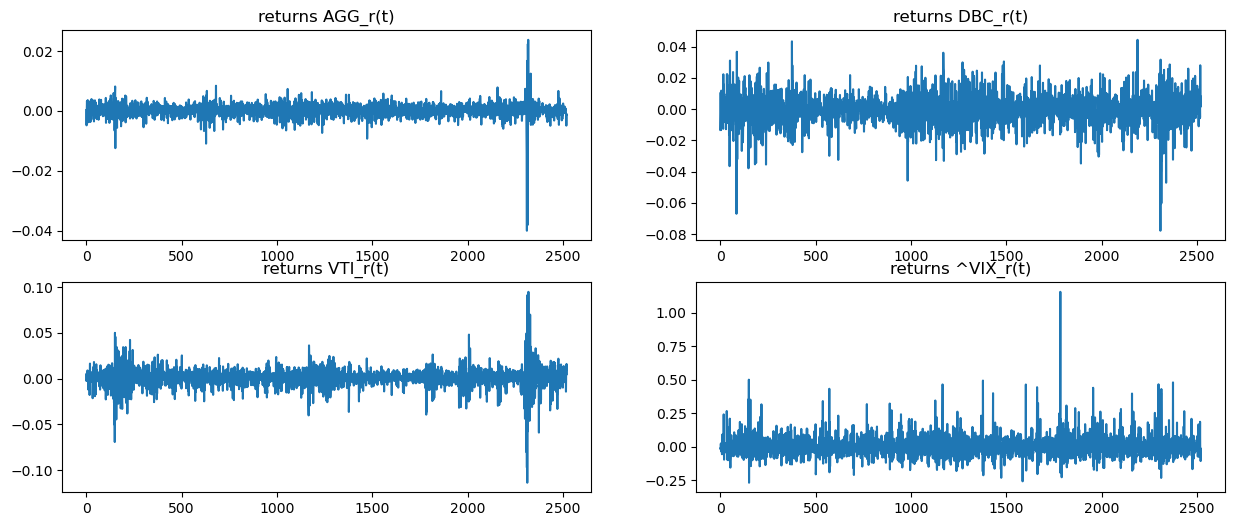

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

axes = axes.flatten()

for i, ticker in enumerate(tickers):
    axes[i].plot(returns[ticker].values)
    axes[i].set_title(f"returns {ticker}")
plt.show()


## Mean-variance optimisation (sharpe ratio optimisation)

In [15]:
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    # Calculate the Sharpe ratio
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe  # Minimizing, so we return the negative Sharpe ratio

def optimize_portfolio(returns, risk_free_rate=0, window=50):
    num_assets = returns.shape[1]

    weights_init = np.ones(num_assets) / num_assets
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    rolling_returns = returns.rolling(window=window).mean().dropna()
    rolling_cov_matrix = returns.rolling(window=window).cov().dropna()

    weights_matrix = np.zeros((len(rolling_returns), num_assets))

    for day in range(len(rolling_returns)):
        mean_returns = rolling_returns.iloc[day]
        cov_matrix = rolling_cov_matrix.loc[rolling_returns.index[day]]

        result = minimize(
            sharpe_ratio,
            weights_init,
            args=(mean_returns, cov_matrix, risk_free_rate),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        weights_matrix[day] = result.x

    return pd.DataFrame(weights_matrix, index=rolling_returns.index, columns=returns.columns)


In [16]:
weights_mv=optimize_portfolio(returns)

In [42]:
weight_array = weights_mv.to_numpy()

2472

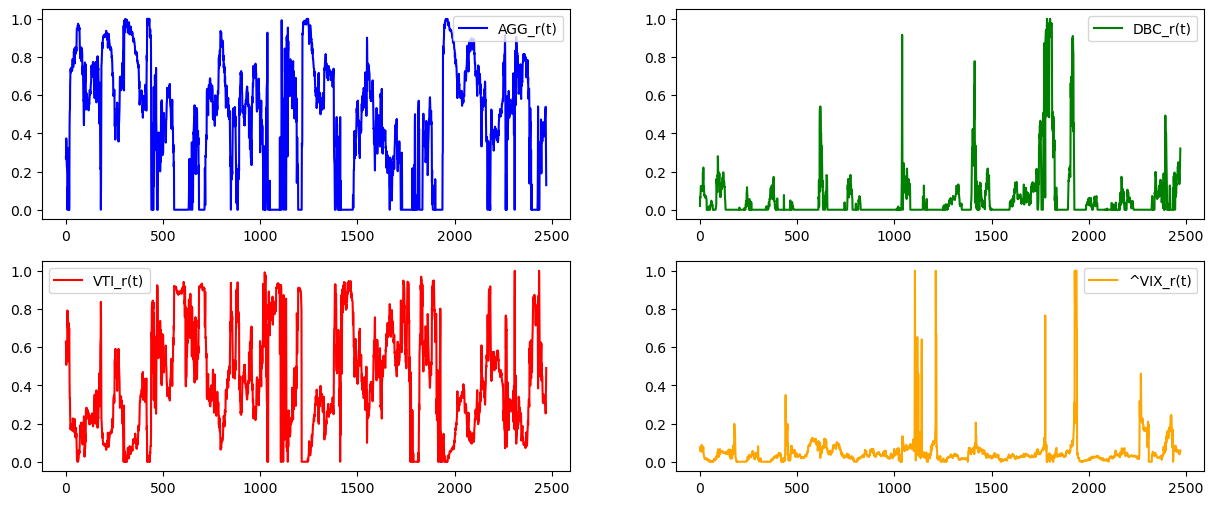

In [24]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
colors = ['blue', 'green', 'red', 'orange']
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].plot(weights_mv.iloc[:,i].values, label=tickers[i], color=colors[i])
    axs[i].legend()


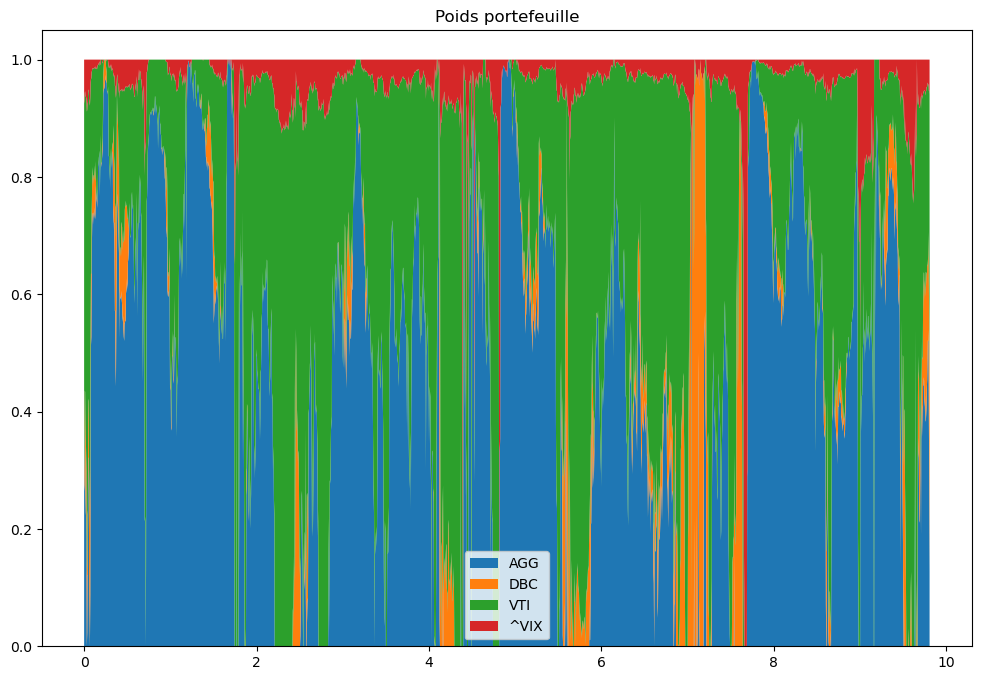

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 8))

axes.set_title("Poids portefeuille")
axes.stackplot(t[0:len(weight_array)], *weight_array.T)
axes.legend(['AGG', 'DBC', 'VTI', '^VIX'])


In [55]:
selected_returns = returns


In [56]:
returns

Ticker,AGG_r(t),DBC_r(t),VTI_r(t),^VIX_r(t)
0,0.000283,-0.013372,-0.001982,-0.013061
1,-0.004826,0.010623,0.005499,-0.020713
2,0.000190,-0.013411,-0.002278,0.022327
3,0.003234,-0.003674,-0.002284,-0.014943
4,0.002654,0.011799,0.000763,0.023337
...,...,...,...,...
2516,-0.001269,-0.005442,-0.014232,0.185494
2517,-0.001017,0.028044,0.008078,-0.060437
2518,-0.004919,0.001331,0.008996,-0.010655
2519,-0.001022,0.004651,0.016038,-0.107698


In [57]:
weighted_returns = selected_returns.values * weights_mv.values

# Sum across columns to obtain daily portfolio returns
portfolio_mv_returns = weighted_returns.sum(axis=1)
portfolio_mv_returns = pd.DataFrame(portfolio_mv_returns, columns=["portfolio_mv_returns"])

# Calculate cumulative returns
portfolio_mv_returns["cumulative_rets"] = (1 + portfolio_mv_returns["portfolio_mv_returns"]).cumprod() - 1


ValueError: operands could not be broadcast together with shapes (2521,4) (2472,4) 

In [19]:
portfolio_returns = weighted_returns.sum(axis=1)

In [20]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_returns.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_returns.std() * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


Espérance des rendements : 0.2291
Standard déviation : 0.1361
Sharpe ratio : 1.6829


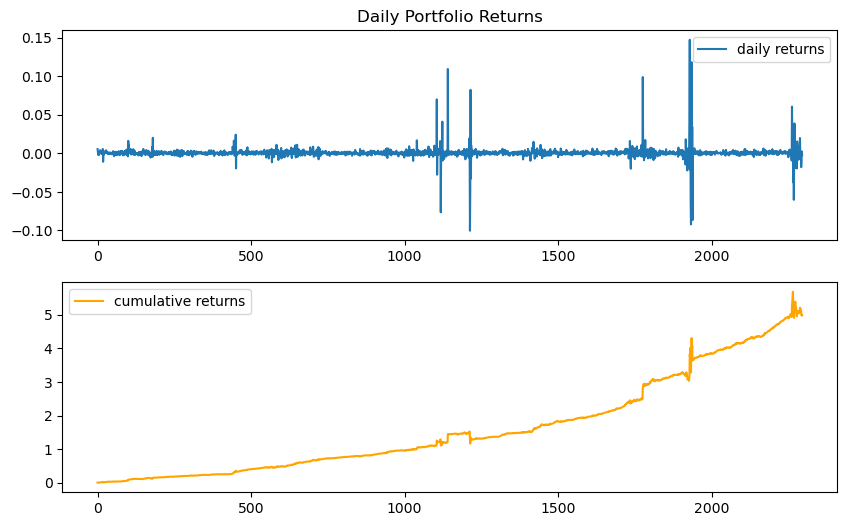

In [54]:


fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot daily returns
axs[0].plot(portfolio_mv_returns["portfolio_mv_returns"].values, label="daily returns")
axs[0].legend()
axs[0].set_title("Daily Portfolio Returns")

# Plot cumulative returns
axs[1].plot(portfolio_mv_returns["cumulative_rets"].values, label="cumulative returns", color='orange')
axs[1].legend()


## Cout de transac

In [33]:
C = 0.001

# Initialisation du vecteur des coûts de transaction
transaction_costs = np.zeros(len(weights_mv))

# Calcul des coûts de transaction
for t in range(2, len(weights_mv)):
    # Calcul des différences de poids
    diff_weights = weights_mv.iloc[t - 1].values - weights_mv.iloc[t - 2].values
    
    # Somme des valeurs absolues des différences
    sum_abs_diff = np.sum(np.abs(diff_weights))
    
    # Coût de transaction pour le temps t
    transaction_costs[t] = C * sum_abs_diff


In [34]:
portfolio_with_transac_cost = portfolio_returns - transaction_costs

In [35]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_with_transac_cost.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_with_transac_cost.std()
std_dev = std_dev * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


Espérance des rendements : 0.1940
Standard déviation : 0.1358
Sharpe ratio : 1.4287
